In [312]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns 
import json
import requests
from sklearn.preprocessing import StandardScaler
import plotly.express as px


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

import sklearn.model_selection as model_selection

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import RidgeCV, LassoCV
import math as m

from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report

In [313]:
trade_data = pd.read_csv("E:\\New folder\\2010_2021_HS2_import.csv")
diesel = pd.read_csv("E:\\New folder\\diesel.csv")
petrol = pd.read_csv("E:\\New folder\\petrol.csv")
indiaCPI = pd.read_csv("E:\\New folder\\india_CPI.csv")
indiaECO = pd.read_csv("E:\\New folder\\indianEco.csv")
commodity_bucket = pd.read_csv("C:\\Users\\hi\Documents\\CommodityBucket.csv")

In [314]:
trade_data = trade_data.drop_duplicates()
diesel = diesel.drop_duplicates()
petrol = petrol.drop_duplicates()
indiaCPI = indiaCPI.drop_duplicates()
indiaECO = indiaECO.drop_duplicates()
commodity_bucket = commodity_bucket.drop_duplicates()

In [315]:
desired_years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [316]:
#Trade Data Chnages
TD_mask = trade_data['year'].isin(desired_years)
trade_data = trade_data[TD_mask]
trade_data = pd.merge(trade_data, commodity_bucket, on='Commodity', how='left')
trade_data = trade_data.rename(columns = {'value': 'trade_import_value', 'Goods': 'commodity_group'})
trade_data = trade_data.drop('HSCode', axis=1)
trade_data = trade_data[trade_data['commodity_group'] != 'Exclude']

In [317]:
trade_data

,Commodity,trade_import_value,country,year,commodity_group
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices
3,CEREALS.,NaN,AFGHANISTAN,2013,Cereals and products
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats
...,...,...,...,...,...
67284,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants"
67287,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects
67290,COTTON.,NaN,ZIMBABWE,2020,Clothing
67293,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light


In [318]:
# Diesel Data Changes
diesel
diesel['date'] = pd.to_datetime(diesel['date'])
diesel['year'] = diesel['date'].dt.year

D_mask = diesel['year'].isin(desired_years)
diesel = diesel[D_mask]
diesel = diesel.groupby('year').agg({'rate':'mean'})
diesel = diesel.rename(columns = {'rate': 'avg_diesel_rate'})

In [319]:
diesel

,avg_diesel_rate
year,
2013,53.362955
2014,58.347250
2015,49.733416
2016,52.978217
2017,58.393915
2018,69.474642
2019,67.921024
2020,70.286237


In [320]:
# Trade Date + Diesel Data

trade_data = pd.merge(trade_data, diesel, on='year', how='left')

In [321]:
# Petrol Data Changes
petrol
petrol['date'] = pd.to_datetime(petrol['date'])
petrol['year'] = petrol['date'].dt.year

P_mask = petrol['year'].isin(desired_years)
petrol = petrol[P_mask]
petrol = petrol.groupby('year').agg({'rate':'mean'})
petrol = petrol.rename(columns = {'rate': 'avg_petrol_rate'})

In [322]:
petrol

,avg_petrol_rate
year,
2013,73.846333
2014,74.253467
2015,65.912258
2016,65.567559
2017,71.239247
2018,79.069544
2019,75.559810
2020,80.143354


In [323]:
# Trade Date + petrol Data

trade_data = pd.merge(trade_data, petrol, on='year', how='left')

In [324]:
trade_data

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333
3,CEREALS.,NaN,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333
...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354
43549,COTTON.,NaN,ZIMBABWE,2020,Clothing,70.286237,80.143354
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354


In [325]:
# India Economy Data Changes

indiaECO
inE_mask = indiaECO['Year'].isin(desired_years)
indiaECO = indiaECO[inE_mask]
indiaECO = indiaECO.drop('Country Name', axis=1)
indiaECO = indiaECO.rename(columns = {'Year': 'year'})

In [326]:
# Trade Date + India Economy Date

trade_data = pd.merge(trade_data, indiaECO, on='year', how='left')

In [327]:
trade_data

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
3,CEREALS.,NaN,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43549,COTTON.,NaN,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [328]:
# India CPI Data Changes
indiaCPI
indiaCPI = indiaCPI.rename(columns = {'Year': 'year'})
inC_mask = indiaCPI['year'].isin(desired_years)
indiaCPI = indiaCPI[inC_mask]
indiaCPI = indiaCPI[indiaCPI['Sector'].isin(['Rural+Urban'])]
indiaCPI = indiaCPI.drop(['Sector', 'Month', 'Miscellaneous', 'General index'], axis=1)
indiaCPI = indiaCPI.groupby('year').mean()

indiaCPI = indiaCPI.reset_index().melt(id_vars=['year'], value_vars=['Cereals and products', 'Meat and fish', 'Egg', 'Milk and products',
       'Oils and fats', 'Fruits', 'Vegetables', 'Pulses and products',
       'Sugar and Confectionery', 'Spices', 'Non-alcoholic beverages',
       'Prepared meals, snacks, sweets etc.', 'Food and beverages',
       'Pan, tobacco and intoxicants', 'Clothing', 'Footwear',
       'Clothing and footwear', 'Fuel and light',
       'Household goods and services', 'Health', 'Transport and communication',
       'Recreation and amusement', 'Education', 'Personal care and effects'], var_name='Goods', value_name='CPI')
indiaCPI = indiaCPI.rename(columns = {'Goods': 'commodity_group'})

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\792484730.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  indiaCPI = indiaCPI.groupby('year').mean()


In [329]:
indiaCPI

,year,commodity_group,CPI
0,2013,Cereals and products,114.083333
1,2014,Cereals and products,121.783333
2,2015,Cereals and products,124.183333
3,2016,Cereals and products,128.500000
4,2017,Cereals and products,133.983333
...,...,...,...
187,2016,Personal care and effects,119.583333
188,2017,Personal care and effects,124.141667
189,2018,Personal care and effects,129.975000
190,2019,Personal care and effects,136.590909


In [330]:
# Trade Date + India CPI Data

trade_data = pd.merge(trade_data, indiaCPI, on=['commodity_group', 'year'], how='left')

In [331]:
trade_data

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,NaN,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,NaN,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [332]:
trade_data = trade_data.fillna(0)

In [333]:
X = trade_data.drop(['Commodity', 'trade_import_value', 'country', 'year', 'commodity_group',
 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Inflation, consumer prices (annual %)', 
       'Population growth (annual %)', 'CPI'], axis=1)
y = trade_data['CPI']



In [334]:
# Final Data
trade_data

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [335]:
df1=trade_data
df1

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


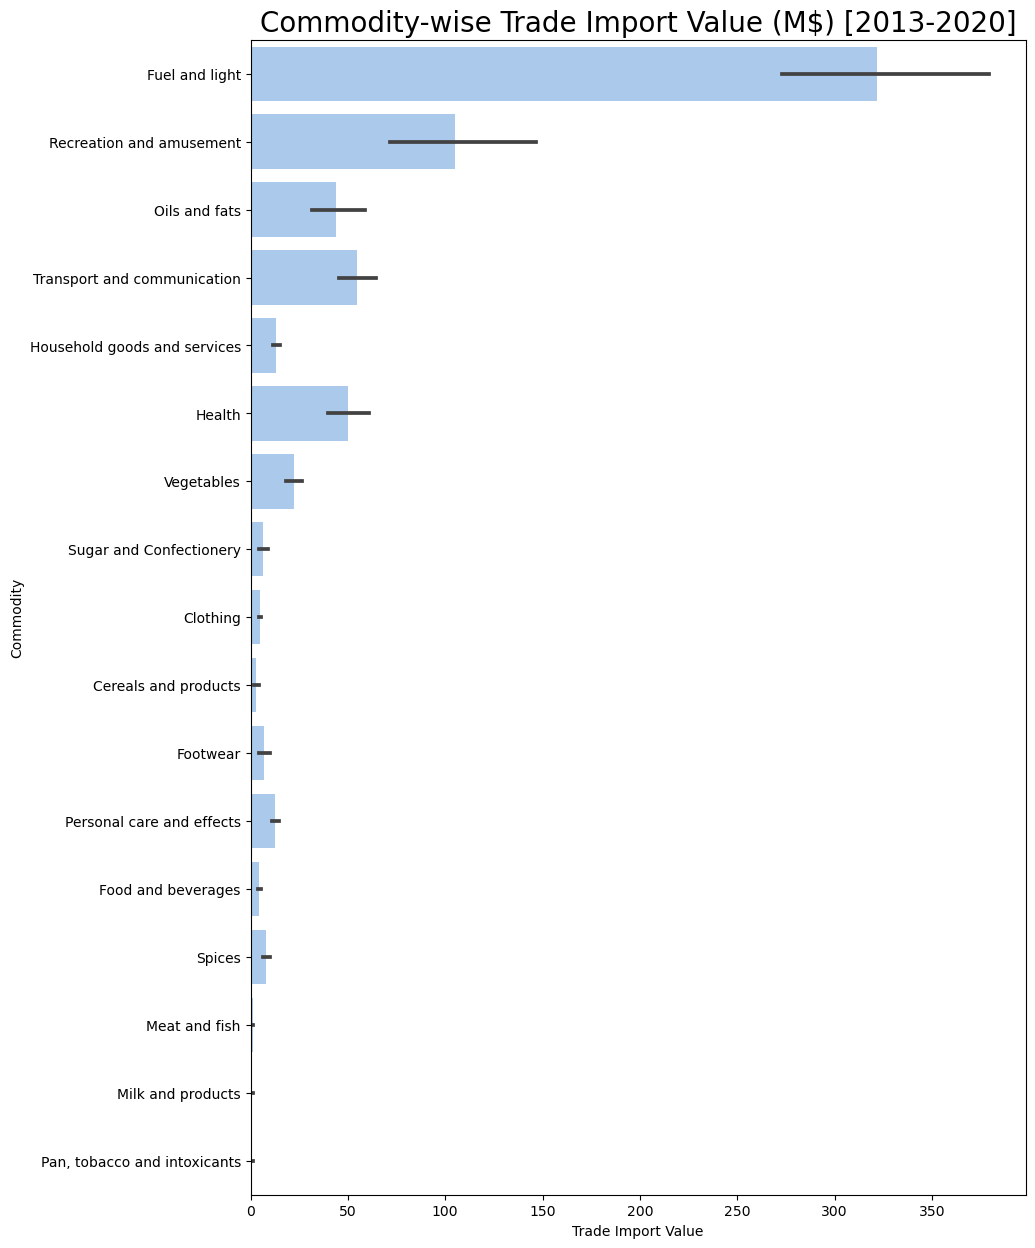

In [337]:
#EDA 1
csv = trade_data
ax = plt.subplots(figsize=(10, 15))

csv_bar_plot = csv.sort_values('trade_import_value',ascending = False)


sns.set_color_codes("pastel")

sns.barplot(x="trade_import_value", y="commodity_group", data=csv_bar_plot, color="b")
plt.title('Commodity-wise Trade Import Value (M$) [2013-2020]', fontsize = 20)
plt.xlabel('Trade Import Value')
plt.ylabel('Commodity');
plt.savefig('Commodity.png')

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\2370501544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = csv.corr()


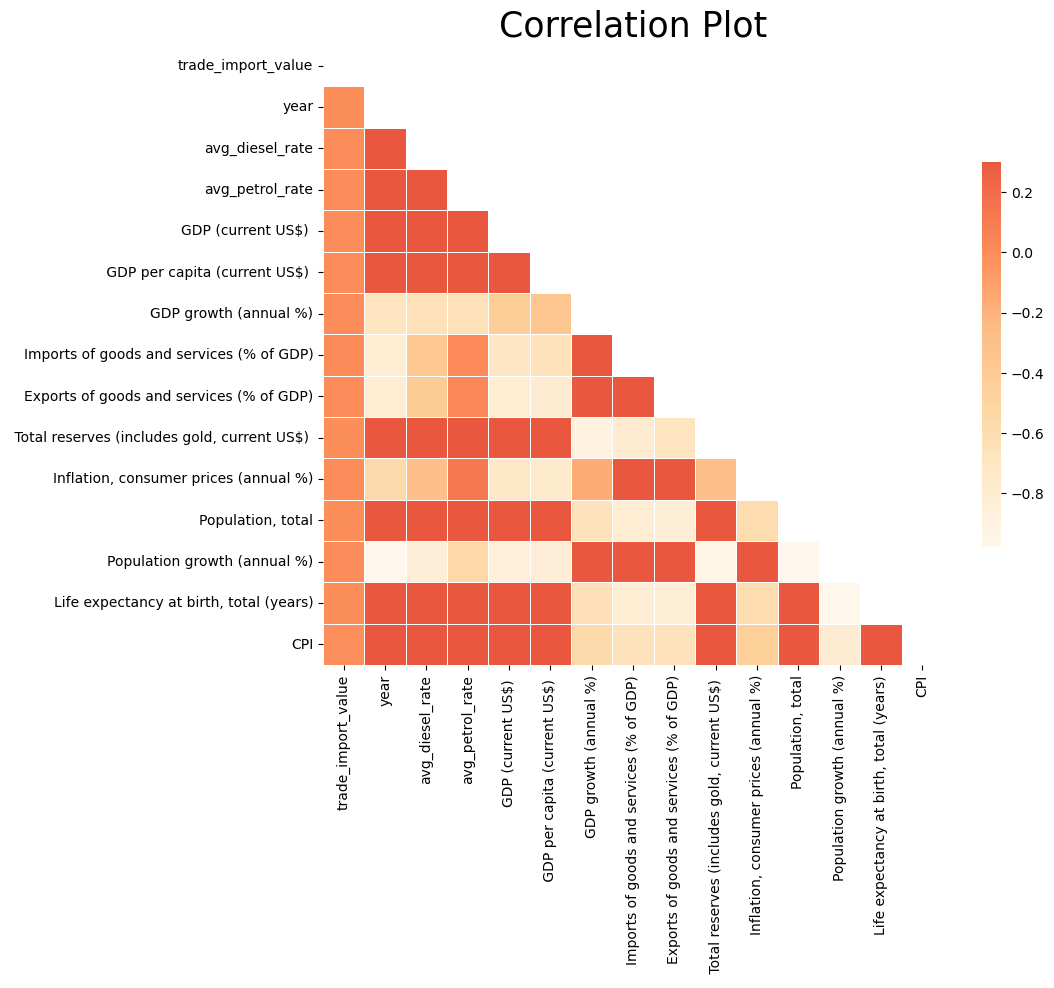

In [338]:
#EDA 2
corr = csv.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap="OrRd", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Plot", fontsize = 25)
plt.savefig('Correlation.png')

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\3817458214.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['avg_diesel_rate'] = round(line_plot['avg_diesel_rate'])


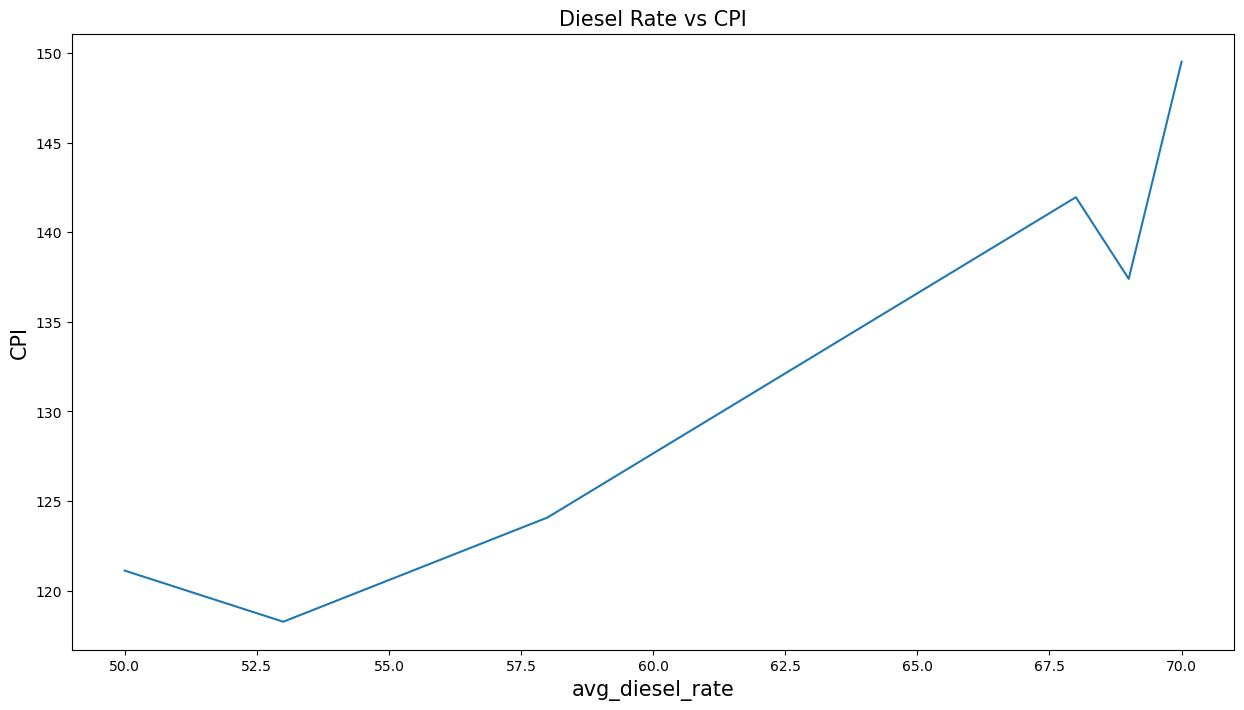

In [339]:
#EDA 3
line_plot = trade_data[['avg_diesel_rate','CPI']]
line_plot['avg_diesel_rate'] = round(line_plot['avg_diesel_rate'])
x = line_plot.groupby('avg_diesel_rate').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['avg_diesel_rate'], x['CPI'],)
plt.title('Diesel Rate vs CPI', fontsize = 15)
plt.xlabel('avg_diesel_rate', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('DieselvsCPI.jpeg')

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\4232124999.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['avg_petrol_rate'] = round(line_plot['avg_petrol_rate'])


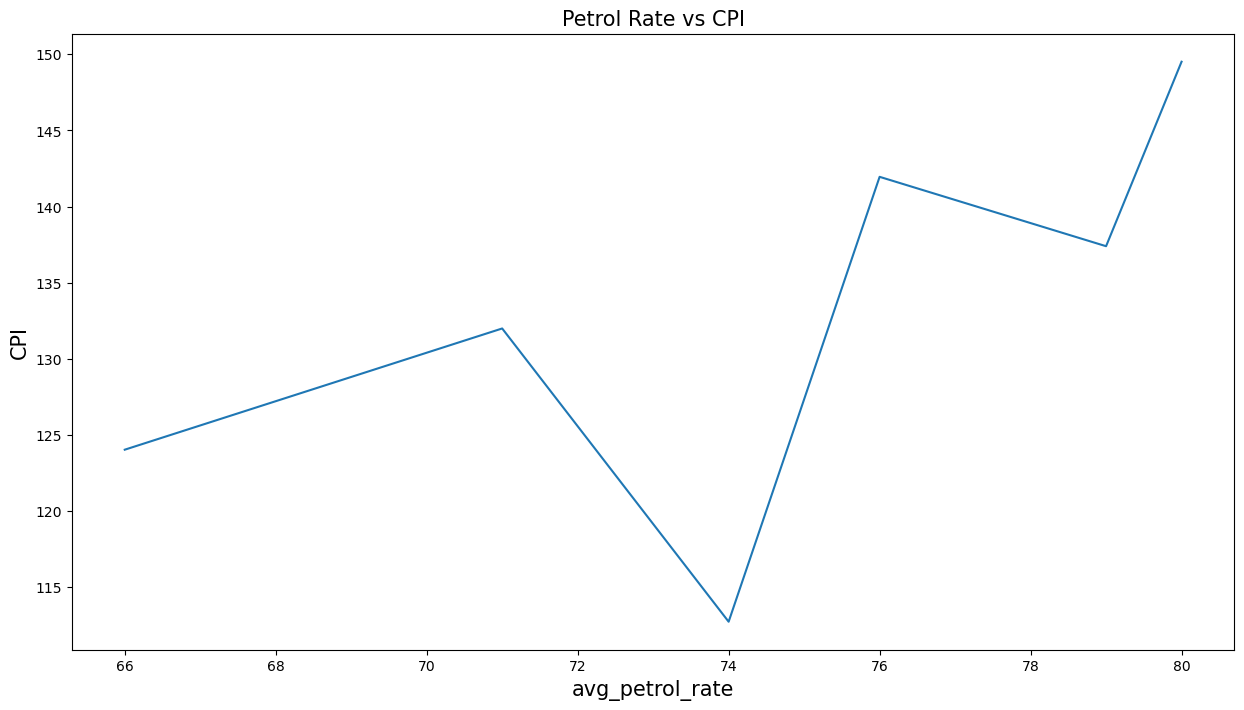

In [340]:
#EDA 4
line_plot = trade_data[['avg_petrol_rate','CPI']]
line_plot['avg_petrol_rate'] = round(line_plot['avg_petrol_rate'])
x = line_plot.groupby('avg_petrol_rate').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['avg_petrol_rate'], x['CPI'],)
plt.title('Petrol Rate vs CPI', fontsize = 15)
plt.xlabel('avg_petrol_rate', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('PetrolvsCPI.jpeg')

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\1176897497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['GDP (current US$) '] = round(line_plot['GDP (current US$) '])


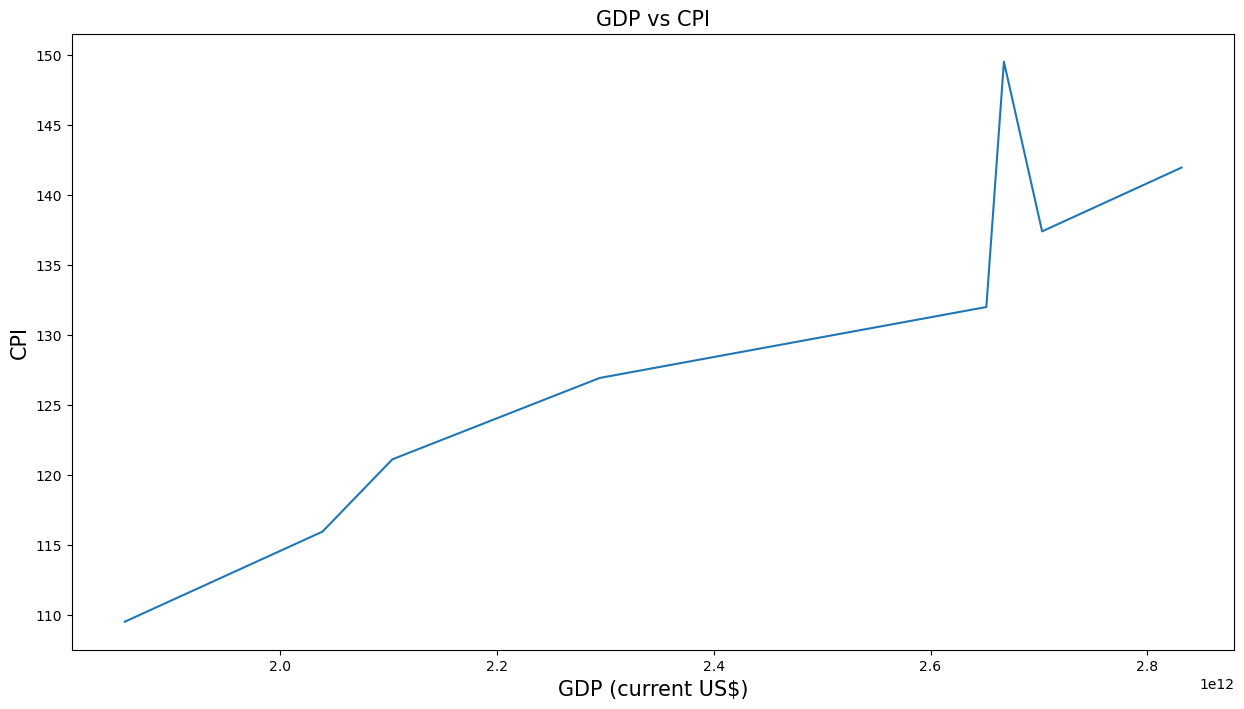

In [341]:
#EDA 5
line_plot = trade_data[['GDP (current US$) ','CPI']]
line_plot['GDP (current US$) '] = round(line_plot['GDP (current US$) '])
x = line_plot.groupby('GDP (current US$) ').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['GDP (current US$) '], x['CPI'],)
plt.title('GDP vs CPI', fontsize = 15)
plt.xlabel('GDP (current US$)', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('GDPvsCPI.jpeg')



C:\Users\hi\AppData\Local\Temp\ipykernel_13476\764459180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['GDP (current US$) '] = round(line_plot['GDP (current US$) '])


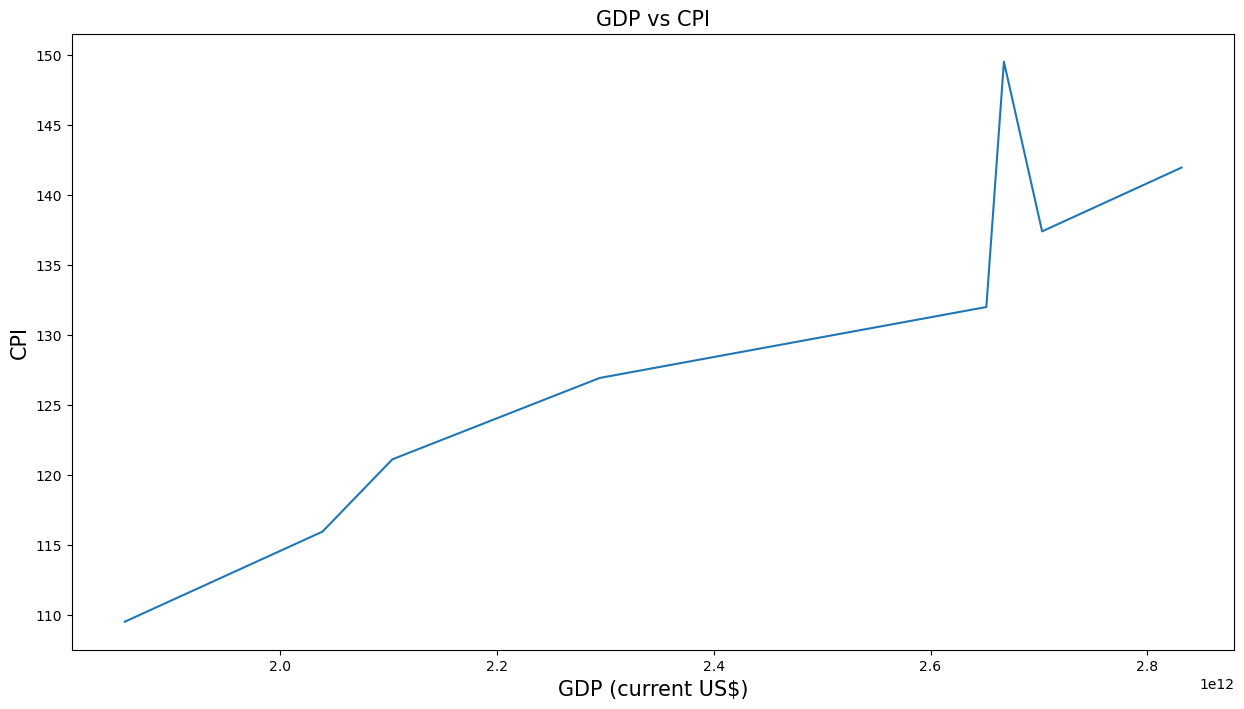

In [342]:
line_plot = trade_data[['GDP (current US$) ','CPI']]
line_plot['GDP (current US$) '] = round(line_plot['GDP (current US$) '])
x = line_plot.groupby('GDP (current US$) ').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['GDP (current US$) '], x['CPI'],)
plt.title('GDP vs CPI', fontsize = 15)
plt.xlabel('GDP (current US$)', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('GDPvsCPI.jpeg')

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\2011455930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot[' Total reserves (includes gold, current US$) '] = round(line_plot[' Total reserves (includes gold, current US$) '])


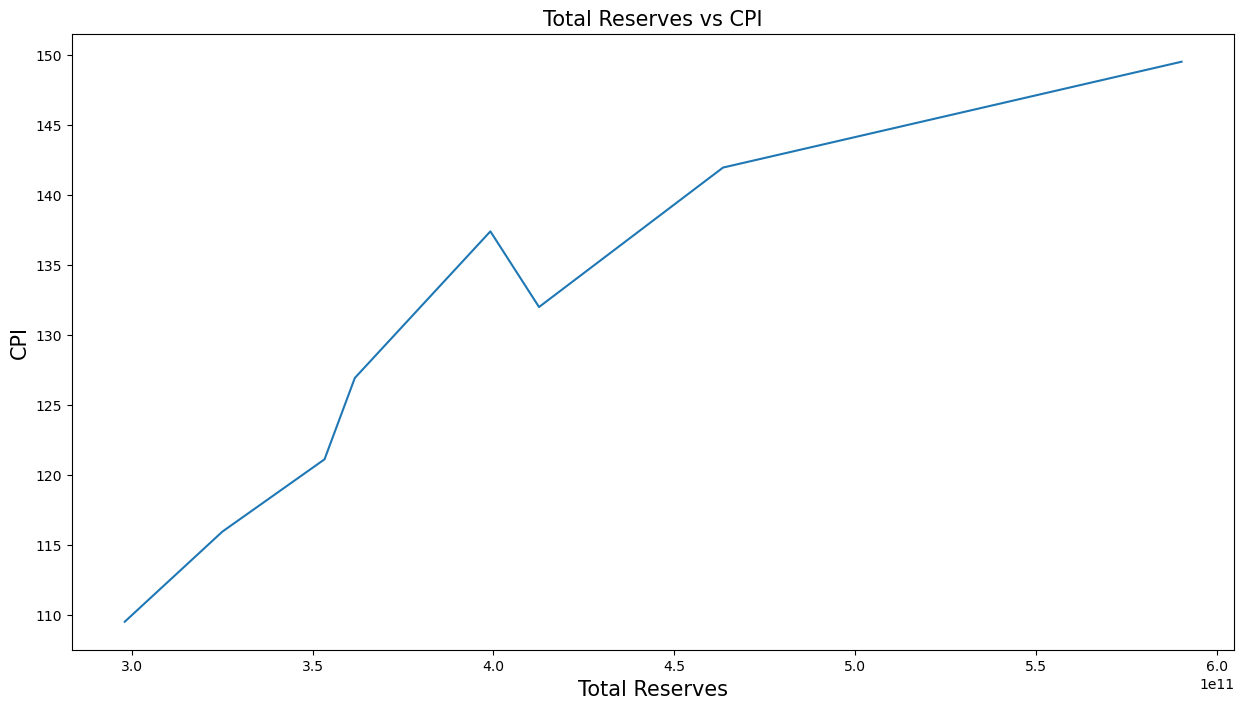

In [343]:
#EDA 6
line_plot = trade_data[[' Total reserves (includes gold, current US$) ','CPI']]
line_plot[' Total reserves (includes gold, current US$) '] = round(line_plot[' Total reserves (includes gold, current US$) '])
x = line_plot.groupby(' Total reserves (includes gold, current US$) ').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x[' Total reserves (includes gold, current US$) '], x['CPI'],)
plt.title('Total Reserves vs CPI', fontsize = 15)
plt.xlabel('Total Reserves', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('ReservesvsCPI.jpeg')



C:\Users\hi\AppData\Local\Temp\ipykernel_13476\2237423417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['Population, total'] = round(line_plot['Population, total'])


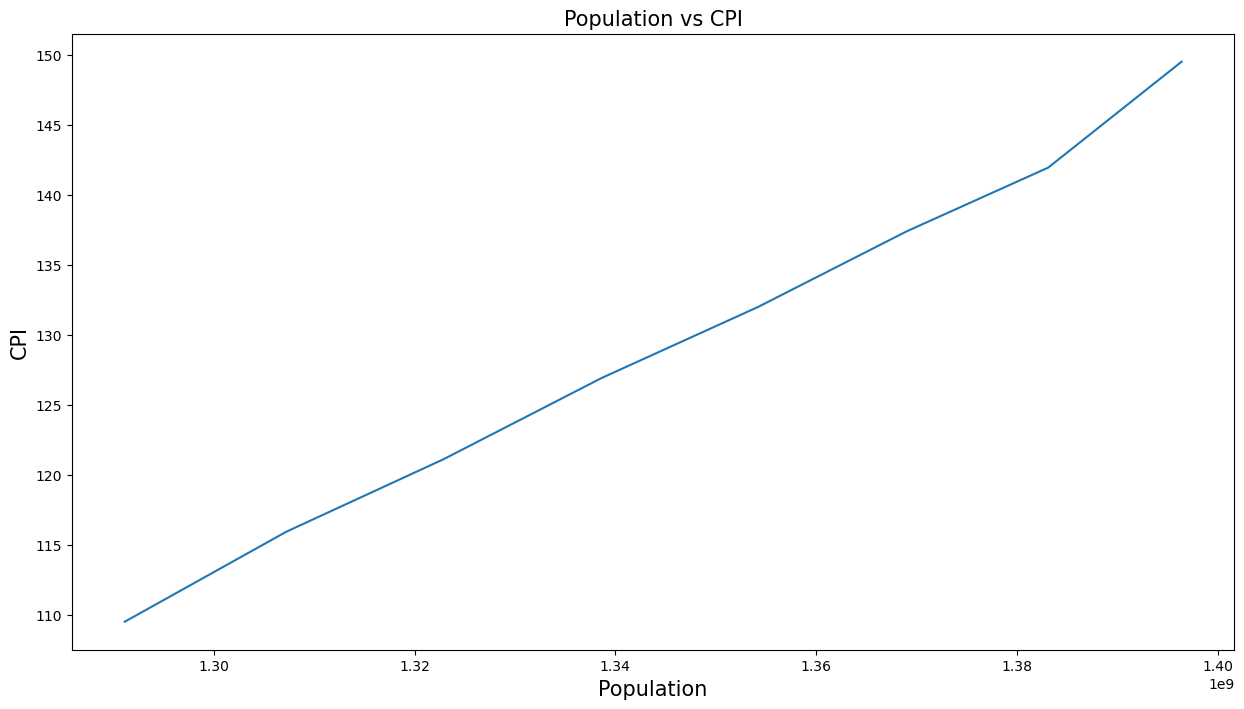

In [344]:
#EDA 7
line_plot = trade_data[['Population, total','CPI']]
line_plot['Population, total'] = round(line_plot['Population, total'])
x = line_plot.groupby('Population, total').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['Population, total'], x['CPI'],)
plt.title('Population vs CPI', fontsize = 15)
plt.xlabel('Population', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('PopulationvsCPI.jpeg')



C:\Users\hi\AppData\Local\Temp\ipykernel_13476\3638772822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  line_plot['Life expectancy at birth, total (years)'] = round(line_plot['Life expectancy at birth, total (years)'])


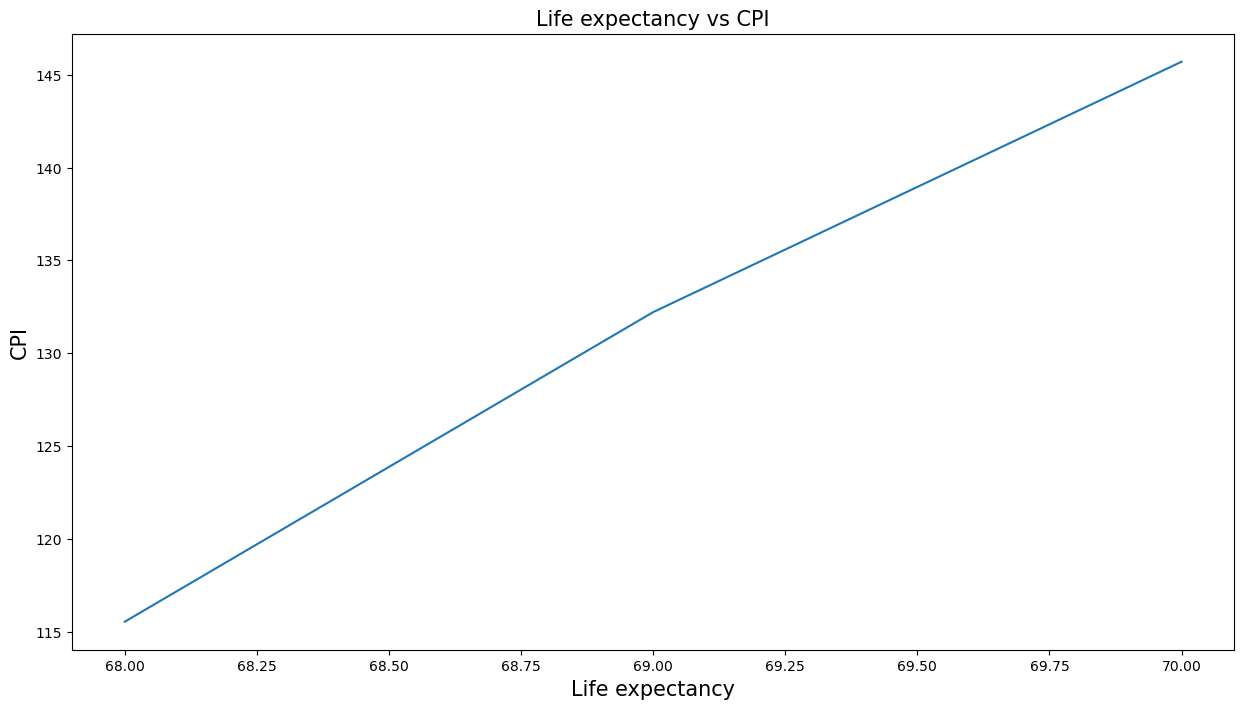

In [345]:
#EDA 8
line_plot = trade_data[['Life expectancy at birth, total (years)','CPI']]
line_plot['Life expectancy at birth, total (years)'] = round(line_plot['Life expectancy at birth, total (years)'])
x = line_plot.groupby('Life expectancy at birth, total (years)').agg({'CPI':'mean'})
x.reset_index(inplace = True)
plt.figure(figsize=(15,8))
plt.plot(x['Life expectancy at birth, total (years)'], x['CPI'],)
plt.title('Life expectancy vs CPI', fontsize = 15)
plt.xlabel('Life expectancy', fontsize = 15)
plt.ylabel('CPI', fontsize = 15)
plt.savefig('LifeExpectancyvsCPI.jpeg')

In [346]:
df1

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [347]:
fin_df.corr()

C:\Users\hi\AppData\Local\Temp\ipykernel_13476\3404627148.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  fin_df.corr()


,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
trade_import_value,1.000000,-0.000931,0.002992,0.004188,0.001423,0.001906,0.003328,0.005606,0.003464,-0.002952,-0.000322,-0.000857,0.001735,-0.000728,-0.013231
year,-0.000931,1.000000,0.833111,0.528013,0.938886,0.907657,-0.674431,-0.805753,-0.811128,0.919986,-0.561483,0.999546,-0.982106,0.998734,0.812556
avg_diesel_rate,0.002992,0.833111,1.000000,0.883593,0.802337,0.775979,-0.644935,-0.373829,-0.404910,0.755514,-0.287326,0.827622,-0.828847,0.828643,0.673553
avg_petrol_rate,0.004188,0.528013,0.883593,1.000000,0.470768,0.437792,-0.644882,0.019110,0.032873,0.557666,0.128880,0.514521,-0.552931,0.513436,0.427681
GDP (current US$),0.001423,0.938886,0.802337,0.470768,1.000000,0.996170,-0.426873,-0.697018,-0.808176,0.760526,-0.729058,0.946662,-0.871459,0.951615,0.755001
GDP per capita (current US$),0.001906,0.907657,0.775979,0.437792,0.996170,1.000000,-0.355781,-0.663944,-0.796995,0.707628,-0.759597,0.917164,-0.831598,0.923111,0.727240
GDP growth (annual %),0.003328,-0.674431,-0.644935,-0.644882,-0.426873,-0.355781,1.000000,0.511319,0.300976,-0.892872,-0.169102,-0.653283,0.747931,-0.639391,-0.562179
Imports of goods and services (% of GDP),0.005606,-0.805753,-0.373829,0.019110,-0.697018,-0.663944,0.511319,1.000000,0.944317,-0.784138,0.623698,-0.809095,0.801932,-0.804451,-0.664923
Exports of goods and services (% of GDP),0.003464,-0.811128,-0.404910,0.032873,-0.808176,-0.796995,0.300976,0.944317,1.000000,-0.676700,0.840400,-0.822836,0.769182,-0.824865,-0.662309
"Total reserves (includes gold, current US$)",-0.002952,0.919986,0.755514,0.557666,0.760526,0.707628,-0.892872,-0.784138,-0.676700,1.000000,-0.284440,0.909791,-0.946850,0.901214,0.755923


In [348]:
df1

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [349]:
df2=df1.drop(['country','commodity_group','year','Commodity'],axis=1)

In [350]:
df2

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [351]:
def outlier_detection(data):
    numeric_columns = data.select_dtypes(include=[np.number])  # Select only numeric columns
    shapes = data.shape
    for col in numeric_columns.columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify and print outliers
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        print(f"Column: {col}, Number of Outliers: {len(outliers)}")

    return data

# Usage
fin_df1 = outlier_detection(df2)

Column: trade_import_value, Number of Outliers: 7961
Column: avg_diesel_rate, Number of Outliers: 0
Column: avg_petrol_rate, Number of Outliers: 0
Column: GDP (current US$) , Number of Outliers: 0
Column:  GDP per capita (current US$) , Number of Outliers: 0
Column: GDP growth (annual %), Number of Outliers: 5642
Column: Imports of goods and services (% of GDP), Number of Outliers: 5264
Column: Exports of goods and services (% of GDP), Number of Outliers: 10524
Column:  Total reserves (includes gold, current US$) , Number of Outliers: 0
Column: Inflation, consumer prices (annual %), Number of Outliers: 0
Column: Population, total, Number of Outliers: 0
Column: Population growth (annual %), Number of Outliers: 0
Column: Life expectancy at birth, total (years), Number of Outliers: 0
Column: CPI, Number of Outliers: 451


In [352]:
#Linearity

In [353]:
from scipy.stats import pearsonr

for col in fin_df1.columns:
    
    if fin_df[col].dtype in [int, float]:

        correlation, p_value = pearsonr(fin_df[col], fin_df['CPI'])
        print(f'Correlation between {col} and CPI: {correlation:.4f}, p-value: {p_value:.4f}')
    else:
        print(f'Skipping non-numeric column: {col}')


Correlation between trade_import_value and CPI: -0.0132, p-value: 0.0058
Correlation between avg_diesel_rate and CPI: 0.6736, p-value: 0.0000
Correlation between avg_petrol_rate and CPI: 0.4277, p-value: 0.0000
Correlation between GDP (current US$)  and CPI: 0.7550, p-value: 0.0000
Skipping non-numeric column:  GDP per capita (current US$) 
Correlation between GDP growth (annual %) and CPI: -0.5622, p-value: 0.0000
Correlation between Imports of goods and services (% of GDP) and CPI: -0.6649, p-value: 0.0000
Correlation between Exports of goods and services (% of GDP) and CPI: -0.6623, p-value: 0.0000
Correlation between  Total reserves (includes gold, current US$)  and CPI: 0.7559, p-value: 0.0000
Correlation between Inflation, consumer prices (annual %) and CPI: -0.4489, p-value: 0.0000
Skipping non-numeric column: Population, total
Correlation between Population growth (annual %) and CPI: -0.8000, p-value: 0.0000
Correlation between Life expectancy at birth, total (years) and CPI: 0

In [354]:
#normality

In [355]:
from scipy.stats import ,anderson
shapiro(fin_df1['CPI'])

C:\Users\hi\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9665737748146057, pvalue=0.0)

In [356]:
result=anderson(fin_df1['CPI'])
result

AndersonResult(statistic=352.6714161006603, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=129.69014715602944, scale=15.591510537221293)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [357]:
for i in result.critical_values:
    if result.statistic < i:
        print("accept")
    else:
        print("reject")

reject
reject
reject
reject
reject


In [358]:
from scipy.stats import boxcox
values,lamda=boxcox(df2['CPI'])
values

array([2.84192775, 2.84192775, 2.7706244 , ..., 2.88085839, 2.86410484,
       2.86827175])

In [359]:
lamda

-0.2467419571795991

In [360]:
fin_df1['Trans_values']=trans_values
fin_df1

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI,Trans_values
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333,2.794800
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333,2.794800
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000,2.727191
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333,2.748826
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333,2.724585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000,2.875769
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000,2.830060
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000,2.831719
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636,2.815831


In [361]:
result=anderson(fin_df1['Trans_values'])
result

AndersonResult(statistic=388.9701496716516, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.7834692539162984, scale=0.03415110776281223)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [362]:
for i in result.critical_values:
    if i < result.statistic:
        print("accept")
    else:
        print("reject")

accept
accept
accept
accept
accept


In [363]:
#no mutli

In [364]:
x_new=fin_df1.drop('CPI',axis=1).drop('Trans_values',axis=1)
x_new

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [365]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [366]:
data1=[variance_inflation_factor(x_new.values,i) for i in range(len(x_new.columns))]
data1

[1.0000891347666354,
 735735866.1904373,
 841780240.7549436,
 1419798117077.71,
 24592162611.950954,
 10371544867.414808,
 227674094.1514302,
 1526619101.5774984,
 1248644294.345957,
 4661390009.900638,
 265408028.92182198,
 9343276925.760601,
 478792326.8803488]

In [367]:
new_df=pd.DataFrame()
new_df['x']=x_new.columns
new_df['VIF']=data1
new_df

,x,VIF
0,trade_import_value,1.000089e+00
1,avg_diesel_rate,7.357359e+08
2,avg_petrol_rate,8.417802e+08
3,GDP (current US$),1.419798e+12
4,GDP per capita (current US$),2.459216e+10
5,GDP growth (annual %),1.037154e+10
6,Imports of goods and services (% of GDP),2.276741e+08
7,Exports of goods and services (% of GDP),1.526619e+09
8,"Total reserves (includes gold, current US$)",1.248644e+09
9,"Inflation, consumer prices (annual %)",4.661390e+09


In [368]:
x_vf = fin_df1[['trade_import_value', 
 'GDP growth (annual %)', 'Imports of goods and services (% of GDP)',
       'Exports of goods and services (% of GDP)',
       'Inflation, consumer prices (annual %)', 
       'Population growth (annual %)']]
x_vf

,trade_import_value,GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Inflation, consumer prices (annual %)",Population growth (annual %)
0,13.60,6.39,28.41,25.43,10.02,1.31
1,130.10,6.39,28.41,25.43,10.02,1.31
2,7.75,6.39,28.41,25.43,10.02,1.31
3,0.00,6.39,28.41,25.43,10.02,1.31
4,3.32,6.39,28.41,25.43,10.02,1.31
...,...,...,...,...,...,...
43547,4.82,-7.25,19.10,18.71,6.62,0.96
43548,0.12,-7.25,19.10,18.71,6.62,0.96
43549,0.00,-7.25,19.10,18.71,6.62,0.96
43550,0.00,-7.25,19.10,18.71,6.62,0.96


In [369]:
y_vf=fin_df[['CPI']]
y_vf

,CPI
0,133.758333
1,133.758333
2,106.075000
3,114.083333
4,105.158333
...,...
43547,179.900000
43548,151.780000
43549,152.700000
43550,144.163636


In [370]:
#model

In [371]:
import statsmodels.api as sm 
model=sm.OLS(y_vf,x_vf).fit()
model

In [372]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    CPI   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.058e+06
Date:                Fri, 13 Oct 2023   Prob (F-statistic):                        0.00
Time:                        09:16:53   Log-Likelihood:                     -1.6535e+05
No. Observations:               43552   AIC:                                  3.307e+05
Df Residuals:                   43546   BIC:                                  3.308e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
trade_import_value                          -0.0003   8.13e-05     -3.392      0.001      -0.000      -0.000
GDP growth (annual %)                       -3.7737      0.030   -124.135      0.000      -3.833      -3.714
Imports of goods and services (% of GDP)    -8.2800      0.165    -50.194      0.000      -8.603      -7.957
Exports of goods and services (% of GDP)    19.2633      0.283     68.103      0.000      18.709      19.818
Inflation, consumer prices (annual %)      -16.5667      0.086   -192.589      0.000     -16.735     -16.398
Population growth (annual %)                31.2371      1.687     18.512      0.000      27.930      34.545
==============================================================================
Omnibus:                      913.918   Durbin-Watson:                   1.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2023.238
Skew:                          -0.033   Prob(JB):                         0.00
Kurtosis:                       4.054   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [373]:
#model-building---using sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [374]:
x=df2.drop('CPI',axis=1)
y=df2['CPI']

In [375]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=0)

In [376]:
x.shape

(43552, 14)

In [377]:
xtrain.shape

(34841, 14)

In [378]:
ytrain.shape


(34841,)

In [379]:
model=LinearRegression().fit(xtrain,ytrain)

In [380]:
model.coef_

array([-2.58137033e-05, -1.33352183e-01,  1.26178857e-01, -2.60326121e-11,
        3.15012892e-02, -6.99658518e-02,  1.62572161e-01,  1.01420236e-01,
        1.80260877e-12,  1.09096881e-01,  7.52733306e-08, -1.63890829e-03,
        7.74086416e-04,  4.60794888e+02])

In [381]:
predicted=model.predict(xtest)

In [382]:
predicted

array([121.5142497 , 134.84711744, 141.02179912, ..., 110.91437921,
       145.79062517, 138.84061877])

In [386]:
from sklearn.metrics import r2_score

In [387]:
test_accuracy = r2_score(ytest,predicted)

In [388]:
test_accuracy

0.9936755574846167

In [389]:
train_pred=model.predict(xtrain)

In [390]:
train_accuracy = r2_score(ytrain,train_pred)
train_accuracy

0.9935544716292032

In [391]:
regression_model = LinearRegression()
regression_model.fit(xtrain, ytrain)
y_pred = regression_model.predict(xtest)
r2 = r2_score(ytest, y_pred)
print("R-squared (R2) Score:", r2)


R-squared (R2) Score: 0.9936755574846167


In [394]:
from sklearn.metrics import mean_absolute_error

In [395]:
regression_model = LinearRegression()
regression_model.fit(xtrain, ytrain)


y_pred = regression_model.predict(xtest)


mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)


Mean Absolute Error: 0.6774186216674953
Mean Squared Error: 1.5467464573200578


# SVM regression

In [143]:
df3=trade_data


In [144]:
df3

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,AFGHANISTAN,2013,Vegetables,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,AFGHANISTAN,2013,Spices,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,AFGHANISTAN,2013,Cereals and products,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,AFGHANISTAN,2013,Oils and fats,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,ZIMBABWE,2020,"Pan, tobacco and intoxicants",70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,ZIMBABWE,2020,Personal care and effects,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,ZIMBABWE,2020,Clothing,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,ZIMBABWE,2020,Fuel and light,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [145]:
df3.columns

Index(['Commodity', 'trade_import_value', 'country', 'year', 'commodity_group',
       'avg_diesel_rate', 'avg_petrol_rate', 'GDP (current US$) ',
       ' GDP per capita (current US$) ', 'GDP growth (annual %)',
       'Imports of goods and services (% of GDP)',
       'Exports of goods and services (% of GDP)',
       ' Total reserves (includes gold, current US$) ',
       'Inflation, consumer prices (annual %)', 'Population, total',
       'Population growth (annual %)',
       'Life expectancy at birth, total (years)', 'CPI'],
      dtype='object')

In [188]:
df_1=df3.drop(['Commodity','commodity_group','country'],axis=1)

In [189]:
df_1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [190]:
df_1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [191]:
df_1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [192]:
Q1 = df_1['CPI'].quantile(0.25)
Q3 = df_1['CPI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [193]:
df_0=df_1[df_1['CPI']<=upper_bound]

In [194]:
df_0

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43546,0.56,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,158.027273
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


C:\Users\hi\anaconda3\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


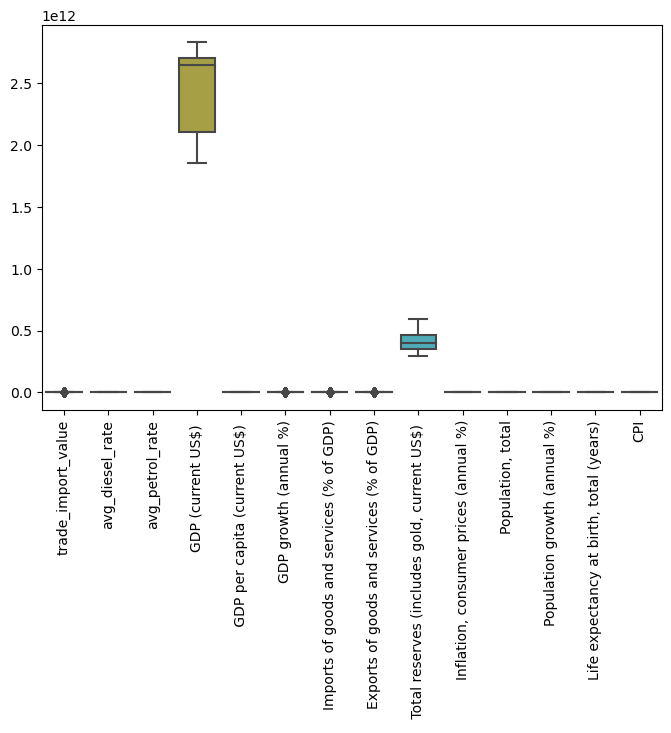

In [295]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df, ax=ax)
ax.tick_params(axis='x', rotation=90)  

plt.show()

In [196]:
from sklearn.model_selection import train_test_split

In [197]:
x=df_0.drop('CPI',axis=1)
x

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43546,0.56,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [198]:
y=df_0['CPI']

In [199]:
y

0        133.758333
1        133.758333
2        106.075000
3        114.083333
4        105.158333
            ...    
43546    158.027273
43548    151.780000
43549    152.700000
43550    144.163636
43551    146.230000
Name: CPI, Length: 43101, dtype: float64

In [200]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.20,random_state=0)

In [201]:
xtrain

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
37680,0.10,2019,67.921024,75.559810,2.831552e+12,2101,4.04,21.27,18.69,4.634699e+11,3.73,1383112050,1.03,69.50
33199,0.00,2019,67.921024,75.559810,2.831552e+12,2101,4.04,21.27,18.69,4.634699e+11,3.73,1383112050,1.03,69.50
17237,27.83,2016,52.978217,65.567559,2.294798e+12,1733,8.26,20.92,19.16,3.616943e+11,4.95,1338636340,1.19,68.67
12099,0.02,2015,49.733416,65.912258,2.103588e+12,1606,8.00,22.11,19.81,3.533191e+11,4.91,1322866505,1.19,68.37
22464,0.21,2017,58.393915,71.239247,2.651473e+12,1981,6.80,21.95,18.79,4.126138e+11,3.33,1354195680,1.16,68.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32103,3679.53,2018,69.474642,79.069544,2.702930e+12,1997,6.53,23.69,19.93,3.991672e+11,3.94,1369003306,1.09,69.27
30403,0.01,2018,69.474642,79.069544,2.702930e+12,1997,6.53,23.69,19.93,3.991672e+11,3.94,1369003306,1.09,69.27
21243,924.14,2017,58.393915,71.239247,2.651473e+12,1981,6.80,21.95,18.79,4.126138e+11,3.33,1354195680,1.16,68.97
43011,6.75,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [202]:
from sklearn.preprocessing import StandardScaler 

In [203]:
scaled=StandardScaler().fit(xtrain)
scaled=StandardScaler().fit(xtest)

In [204]:
xtrain_scaled=scaled.transform(xtrain)
xtest_scaled=scaled.transform(xtest)

In [205]:
xtrain_scaled_df=pd.DataFrame(xtrain_scaled,columns=x.columns)
xtest_scaled_df=pd.DataFrame(xtest_scaled,columns=x.columns)

In [206]:
xtrain_scaled_df

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,-0.088882,1.093416,1.023691,0.460932,1.268824,1.357714,-0.223252,-0.605848,-0.764078,0.747564,-0.860603,1.091678,-1.095157,1.083775
1,-0.089063,1.093416,1.023691,0.460932,1.268824,1.357714,-0.223252,-0.605848,-0.764078,0.747564,-0.860603,1.091678,-1.095157,1.083775
2,-0.038838,-0.216950,-0.937127,-1.522346,-0.289968,-0.287668,0.676283,-0.731195,-0.560129,-0.443080,-0.270802,-0.191691,0.394911,-0.188916
3,-0.089027,-0.653739,-1.362914,-1.453929,-0.845263,-0.855503,0.620861,-0.305014,-0.278072,-0.541060,-0.290140,-0.646738,0.394911,-0.648925
4,-0.088684,0.219838,-0.226471,-0.396620,0.745854,0.821176,0.365069,-0.362316,-0.720684,0.152612,-1.053980,0.257282,0.115523,0.271093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34475,6.551350,0.656627,1.227559,1.157549,0.895290,0.892715,0.307516,0.260839,-0.226000,-0.004696,-0.759080,0.684563,-0.536382,0.731101
34476,-0.089045,0.656627,1.227559,1.157549,0.895290,0.892715,0.307516,0.260839,-0.226000,-0.004696,-0.759080,0.684563,-0.536382,0.731101
34477,1.578724,0.219838,-0.226471,-0.396620,0.745854,0.821176,0.365069,-0.362316,-0.720684,0.152612,-1.053980,0.257282,0.115523,0.271093
34478,-0.076881,1.530204,1.334057,1.370681,0.792945,0.584206,-2.629828,-1.383002,-0.755399,2.230463,0.536548,1.474737,-1.747061,1.436448


In [207]:
svr_model = SVR()
svr_model.fit(xtrain_scaled, ytrain)

SVR()

In [208]:
svr_model_train_pred = svr_model.predict(xtrain_scaled)
svr_model_test_pred = svr_model.predict(xtest_scaled)

In [209]:
train_r2 = r2_score(ytrain, svr_model_train_pred)
test_r2 = r2_score(ytest, svr_model_test_pred)

print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

y_pred = svr_model.predict(xtest_scaled)

Training R-squared: 0.6680689992441013
Testing R-squared: 0.676166432361172


In [210]:
mae = mean_absolute_error(ytest, y_pred)
mse = mean_squared_error(ytest, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(ytest, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)


Mean Absolute Error: 5.527013546406209
Mean Squared Error: 69.46267841724669
Root Mean Squared Error: 8.334427299895697
R-squared: 0.676166432361172


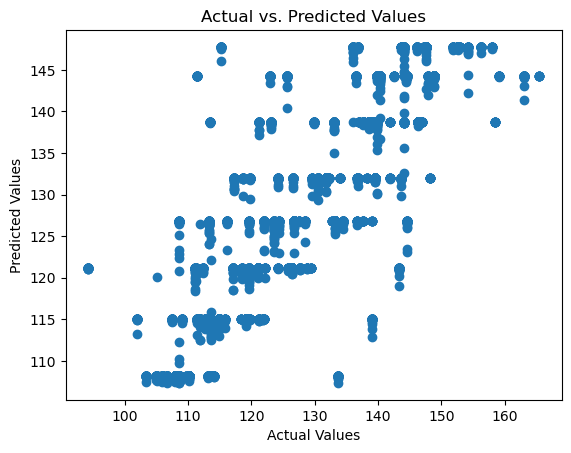

In [211]:
import matplotlib.pyplot as plt

# Visualize actual vs. predicted values
plt.scatter(ytest, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()


In [213]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 1.0]
}

In [ ]:
svr_model = SVR()

grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(xtrain_scaled, ytrain)

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best_svr_model = SVR(**best_params)
best_svr_model.fit(xtrain_scaled, ytrain)


In [212]:

y_pred = best_svr_model.predict(xtest_scaled)

NameError: name 'best_svr_model' is not defined

# navie Bayies Regression

In [214]:
df_2=trade_data

In [215]:
df_2

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,0,2013,16,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,0,2013,16,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,0,2013,13,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,0,2013,0,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,0,2013,9,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,235,2020,10,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,235,2020,11,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,235,2020,1,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,235,2020,4,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [216]:
df1=df_2.drop(['Commodity','country','commodity_group'],axis=1)
df1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [217]:
df1.describe()

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
count,43552.000000,43552.000000,43552.000000,43552.000000,4.355200e+04,43552.000000,43552.000000,43552.000000,43552.000000,4.355200e+04,43552.000000,4.355200e+04,43552.000000,43552.000000,43552.000000
mean,53.061287,2016.571799,60.301834,73.317703,2.404035e+12,1802.978187,4.928344,22.873802,20.390204,4.027794e+11,5.489249,1.346406e+09,1.144166,68.814161,129.690147
std,635.340536,2.295226,7.634824,5.063344,3.420310e+11,221.922201,4.856479,2.785839,2.278569,8.722589e+10,2.046726,3.470125e+07,0.108229,0.652527,15.591511
min,0.000000,2013.000000,49.733416,65.567559,1.856722e+12,1450.000000,-7.250000,19.100000,18.690000,2.980925e+11,3.330000,1.291132e+09,0.960000,67.770000,94.308333
25%,0.000000,2015.000000,53.362955,71.239247,2.103588e+12,1606.000000,4.040000,20.920000,18.710000,3.533191e+11,3.730000,1.322867e+09,1.030000,68.370000,117.041667
50%,0.110000,2017.000000,58.393915,74.253467,2.651473e+12,1928.000000,6.530000,21.950000,19.160000,3.991672e+11,4.910000,1.354196e+09,1.160000,68.970000,129.433333
75%,2.060000,2019.000000,69.474642,79.069544,2.702930e+12,1997.000000,7.410000,23.690000,19.930000,4.634699e+11,6.620000,1.383112e+09,1.190000,69.500000,140.245455
max,32781.570000,2020.000000,70.286237,80.143354,2.831552e+12,2101.000000,8.260000,28.410000,25.430000,5.902274e+11,10.020000,1.396387e+09,1.310000,69.730000,185.554545


In [218]:
df1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [219]:
from sklearn.model_selection import train_test_split

In [220]:
df1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [221]:
x1=df1.drop('CPI',axis=1)
x1

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,13.60,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
1,130.10,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
2,7.75,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
3,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
4,3.32,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43548,0.12,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43549,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73
43550,0.00,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [222]:
y1=df1['CPI']

In [223]:
y1

0        133.758333
1        133.758333
2        106.075000
3        114.083333
4        105.158333
            ...    
43547    179.900000
43548    151.780000
43549    152.700000
43550    144.163636
43551    146.230000
Name: CPI, Length: 43552, dtype: float64

In [224]:
x1train,x1test,y1train,y1test=train_test_split(x1,y1,test_size=0.20,random_state=0)

In [225]:
x1train

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
17426,0.01,2016,52.978217,65.567559,2.294798e+12,1733,8.26,20.92,19.16,3.616943e+11,4.95,1338636340,1.19,68.67
19330,20.34,2016,52.978217,65.567559,2.294798e+12,1733,8.26,20.92,19.16,3.616943e+11,4.95,1338636340,1.19,68.67
48,0.00,2013,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77
11258,0.13,2015,49.733416,65.912258,2.103588e+12,1606,8.00,22.11,19.81,3.533191e+11,4.91,1322866505,1.19,68.37
32972,0.89,2019,67.921024,75.559810,2.831552e+12,2101,4.04,21.27,18.69,4.634699e+11,3.73,1383112050,1.03,69.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32103,3679.53,2018,69.474642,79.069544,2.702930e+12,1997,6.53,23.69,19.93,3.991672e+11,3.94,1369003306,1.09,69.27
30403,0.01,2018,69.474642,79.069544,2.702930e+12,1997,6.53,23.69,19.93,3.991672e+11,3.94,1369003306,1.09,69.27
21243,924.14,2017,58.393915,71.239247,2.651473e+12,1981,6.80,21.95,18.79,4.126138e+11,3.33,1354195680,1.16,68.97
42613,0.01,2020,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73


In [226]:
scaled=StandardScaler().fit(x1train)

In [227]:
x1train_scaled=scaled.transform(x1train)
x1test_scaled=scaled.transform(x1test)

In [228]:
x1train_scaled_df = pd.DataFrame(x1train_scaled, columns=x.columns[:14])
x1test_scaled_df = pd.DataFrame(x1test_scaled, columns=x.columns[:14])

In [229]:
x1train_scaled_df

,trade_import_value,year,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)"
0,-0.084265,-0.250991,-0.958589,-1.526759,-0.321784,-0.317731,0.685495,-0.699101,-0.537360,-0.472516,-0.260880,-0.225826,0.424762,-0.222881
1,-0.052274,-0.250991,-0.958589,-1.526759,-0.321784,-0.317731,0.685495,-0.699101,-0.537360,-0.472516,-0.260880,-0.225826,0.424762,-0.222881
2,-0.084281,-1.560091,-0.908175,0.106891,-1.604491,-1.594780,0.300613,1.993666,2.219427,-1.202127,2.219463,-1.596989,1.534940,-1.604404
3,-0.084076,-0.687358,-1.383770,-1.458740,-0.881657,-0.890824,0.631982,-0.271278,-0.251568,-0.568593,-0.280449,-0.681007,0.424762,-0.683389
4,-0.082880,1.058108,0.999436,0.445012,1.249858,1.342885,-0.183062,-0.573271,-0.744009,0.695006,-0.857728,1.057920,-1.055475,1.051190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34836,5.705711,0.621742,1.203013,1.137587,0.873245,0.873581,0.329428,0.296755,-0.198807,-0.042645,-0.754992,0.650685,-0.500386,0.698134
34837,-0.084265,0.621742,1.203013,1.137587,0.873245,0.873581,0.329428,0.296755,-0.198807,-0.042645,-0.754992,0.650685,-0.500386,0.698134
34838,1.369917,0.185375,-0.248945,-0.407565,0.722577,0.801380,0.384999,-0.328801,-0.700041,0.111609,-1.053415,0.223278,0.147218,0.237627
34839,-0.084265,1.494475,1.309360,1.349482,0.770056,0.562215,-2.506760,-1.353418,-0.735215,2.149109,0.556117,1.441091,-1.703079,1.404246


In [230]:
from sklearn.naive_bayes import GaussianNB

In [231]:
model = LinearRegression()
model.fit(x1train, y1train)
y_pred = model.predict(x1test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 80.84136893298732
Root Mean Squared Error: 8.991182843930343
Mean Absolute Error: 6.018517039626613
R-squared: 0.6694502914411533


In [233]:
from sklearn.impute import SimpleImputer
regression_model = LinearRegression()
imputer = SimpleImputer(strategy='mean')
x1train = imputer.fit_transform(x1train)
regression_model.fit(x1train, y1train)
x1test = imputer.transform(x1test)
y_pred = regression_model.predict(x1test)
mse = mean_squared_error(y1test, y_pred)
r2 = r2_score(y1test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 80.84136893298732
R-squared: 0.6694502914411533


In [234]:
coefficients = regression_model.coef_
intercept = regression_model.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)


Coefficients: [-3.07928164e-04 -5.34513287e-03  2.73175000e-01 -2.13997940e-01
  4.01727250e-11 -5.37418025e-02 -1.91192373e-02 -2.34352784e-01
 -5.17831836e-02  1.09473419e-11  4.83060244e-02  2.28469617e-07
  6.73863444e-03 -2.02872220e-03]
Intercept: -165.6358918400669


In [235]:
rows_with_nan = np.isnan(x1train).any(axis=1)
x1train = x1train[~rows_with_nan]
y1train = y1train[~rows_with_nan]


In [239]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [240]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0],  # Example hyperparameter for Ridge regression
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],  # Solver options
}
grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(x1train,y1train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.72562e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.73368e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.73237e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.73205e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarnin

In [241]:
best_model



Ridge()

In [242]:
best_params

{'alpha': 1.0, 'solver': 'auto'}

In [243]:
best_hyperparameters = {'alpha': 1.0, 'solver': 'auto'}
best_ridge_model = Ridge(**best_hyperparameters)
best_ridge_model.fit(x1train, y1train)
y1test_pred = best_ridge_model.predict(x1test)

C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.3853e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [244]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y1test, y1test_pred)
r2 = r2_score(y1test, y1test_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")



Mean Squared Error: 80.84
R-squared (R2) Score: 0.67


# Random forest Regression

In [268]:
df4=trade_data

In [271]:
df4

,Commodity,trade_import_value,country,year,commodity_group,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,13.60,0,2013,16,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,EDIBLE FRUIT AND NUTS; PEEL OR CITRUS FRUIT OR...,130.10,0,2013,16,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,"COFFEE, TEA, MATE AND SPICES.",7.75,0,2013,13,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,CEREALS.,0.00,0,2013,0,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,"OIL SEEDS AND OLEA. FRUITS; MISC. GRAINS, SEED...",3.32,0,2013,9,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,TOBACCO AND MANUFACTURED TOBACCO SUBSTITUTES.,4.82,235,2020,10,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,PHARMACEUTICAL PRODUCTS,0.12,235,2020,11,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,COTTON.,0.00,235,2020,1,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,"NUCLEAR REACTORS, BOILERS, MACHINERY AND MECHA...",0.00,235,2020,4,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [272]:
df_4=df4.drop(['Commodity','country','commodity_group','year'],axis=1)
df_4

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [273]:
from scipy import stats

In [274]:
z_scores = stats.zscore(fin_df4)
z_score_threshold = 3
outliers_mask = (z_scores > z_score_threshold).any(axis=1)
no_outliers_mask = ~outliers_mask
data_no_outliers = fin_df4[no_outliers_mask]

In [275]:
z_scores = stats.zscore(fin_df4)
threshold = 3  

outliers_mask = (z_scores > threshold).any(axis=1)
no_outliers_mask = ~outliers_mask
data_no_outliers = fin_df4[no_outliers_mask]

In [276]:
x=fin_df4.drop(['CPI'],axis=1)
y=fin_df4['CPI']

In [277]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [278]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [258]:
y_pred = rf_model.predict(X_test)

In [279]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Squared Error: 93.23
R-squared (R2) Score: 0.62


In [280]:
base_model = RandomForestRegressor(random_state=42)


In [281]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [284]:
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X, y)  

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [285]:
best_params = grid_search.best_params_



In [286]:
best_model = grid_search.best_estimator_

In [287]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")





Mean Squared Error (MSE): 93.23
Root Mean Squared Error (RMSE): 9.66
Mean Absolute Error (MAE): 6.59
R-squared (R2) Score: 0.62


# xGbooster

In [289]:
df_4

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [290]:
df8=df_4

In [291]:
df8

,trade_import_value,avg_diesel_rate,avg_petrol_rate,GDP (current US$),GDP per capita (current US$),GDP growth (annual %),Imports of goods and services (% of GDP),Exports of goods and services (% of GDP),"Total reserves (includes gold, current US$)","Inflation, consumer prices (annual %)","Population, total",Population growth (annual %),"Life expectancy at birth, total (years)",CPI
0,13.60,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
1,130.10,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,133.758333
2,7.75,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,106.075000
3,0.00,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,114.083333
4,3.32,53.362955,73.846333,1.856722e+12,1450,6.39,28.41,25.43,2.980925e+11,10.02,1291132063,1.31,67.77,105.158333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43547,4.82,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,179.900000
43548,0.12,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,151.780000
43549,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,152.700000
43550,0.00,70.286237,80.143354,2.667688e+12,1928,-7.25,19.10,18.71,5.902274e+11,6.62,1396387127,0.96,69.73,144.163636


In [292]:
from sklearn.ensemble import GradientBoostingRegressor
X4= df8.drop(['CPI'],axis=1)
y4= df8['CPI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)


Mean Squared Error (MSE): 84.99588354463891
R-squared (R2) Score: 0.6584709371701465


In [293]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

model = GradientBoostingRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


In [301]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [302]:
 from sklearn.linear_model import Ridge

alpha = 0.01  
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)


C:\Users\hi\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.38663e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.01)

In [305]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

model1 = RandomForestRegressor()
model2 = GradientBoostingRegressor()

ensemble_model = VotingRegressor(estimators=[('rf', model1), ('gb', model2)])
ensemble_model.fit(X_train, y_train)



VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('gb', GradientBoostingRegressor())])

In [306]:
y_pred = ensemble_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")


Mean Squared Error (MSE): 86.96839250626131
R-squared (R2) Score: 0.650545034067644
